<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-preparation-and-single-variable-classification" data-toc-modified-id="Data-preparation-and-single-variable-classification-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data preparation and single variable classification</a></span></li><li><span><a href="#Fischer-(4-vs-57-params)" data-toc-modified-id="Fischer-(4-vs-57-params)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Fischer (4 vs 57 params)</a></span></li><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>XGBoost</a></span></li><li><span><a href="#Shap-Values-and-lightGBM" data-toc-modified-id="Shap-Values-and-lightGBM-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Shap Values and lightGBM</a></span></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import uproot

In [2]:
train_amount = int(1e4)
test_amount = int(1e4)

In [3]:
file = uproot.open("../Data/mc15_13TeV.361203.Pythia8_A2_MSTW2008LO_ND_minbias.30062015_v0_per_0.root")
tree = file['tree']
df = tree.pandas.df("v0_rxy v0_chi2 cosTheta v0_ks_mass v0_rxyErr pT ntrk_pv0 a0 calpha a0xy pv0_y trueKs".split(" "), entrystop = train_amount + test_amount)
df_all = tree.pandas.df(entrystop = train_amount+ test_amount)

## Data preparation and single variable classification

In [4]:
# Normalize data
df_norm = pd.DataFrame(None)
for col in df.columns[:-1]:
    df_norm[col] = (df[col] - df[col].mean()) / df[col].std()

# Seperate truth label
df_label = df.trueKs
    
scalers = {}
    
# Repeat for more data    
df_all_norm = pd.DataFrame(None)
for col in df_all.columns[:57]:
    if df_all[col].std() != 0:
        df_all_norm[col] = (df_all[col] - df_all[col].mean()) / df_all[col].std()
        scalers[col] = [df_all[col].mean(), df_all[col].std()]
        
df_all_label = df_all.trueKs

AUC-scores are: v0_rxy: 0.706, v0_chi2: 0.747, cosTheta: 0.950, v0_ks_mass: 0.508, v0_rxyErr: 0.851, pT: 0.653, ntrk_pv0: 0.620, a0: 0.907, calpha: 0.506, a0xy: 0.886, pv0_y: 0.517


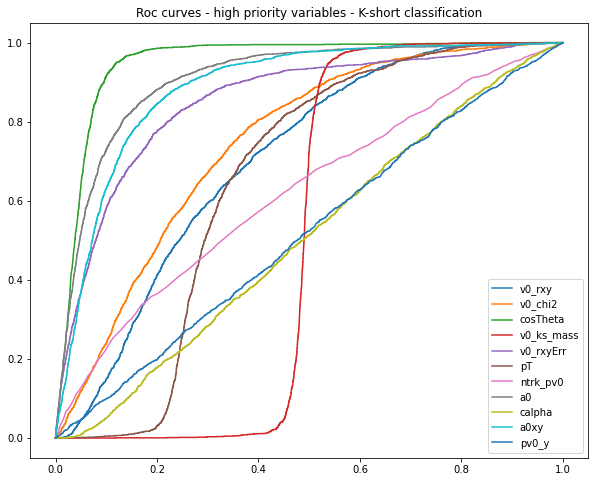

In [5]:
from sklearn.metrics import roc_curve, roc_auc_score

fig, ax = plt.subplots(figsize = (10, 8))

ax.set(title = "Roc curves - high priority variables - K-short classification")
aucs = {} # for recording auc_scores


for col in df_norm:
    auc = roc_auc_score(df_label, df_norm[col])
    if auc < .5:
        auc = 1 - auc
        scores = - df_norm[col]
    else:
        scores = df_norm[col]
    
    aucs[col] = auc
    
    x, y, _ = roc_curve(df_label, scores)
    
    
    
    ax.plot(x, y, label = col)
    

ax.legend(loc = "lower right")

print("AUC-scores are: " + ", ".join([f"{name}: {aucs[name]:.3f}" for name in aucs.keys()]))


In [6]:
# Transform k_short to abs-value
df_norm.v0_ks_mass = abs(df_norm.v0_ks_mass)
# df_norm.v0_rxyErr = abs(df_norm.v0_rxyErr)
df_norm.pT = abs(df_norm.pT)

AUC-scores are: v0_rxy: 0.706, v0_chi2: 0.747, cosTheta: 0.950, v0_ks_mass: 0.927, v0_rxyErr: 0.851, pT: 0.623, ntrk_pv0: 0.620, a0: 0.907, calpha: 0.506, a0xy: 0.886, pv0_y: 0.517


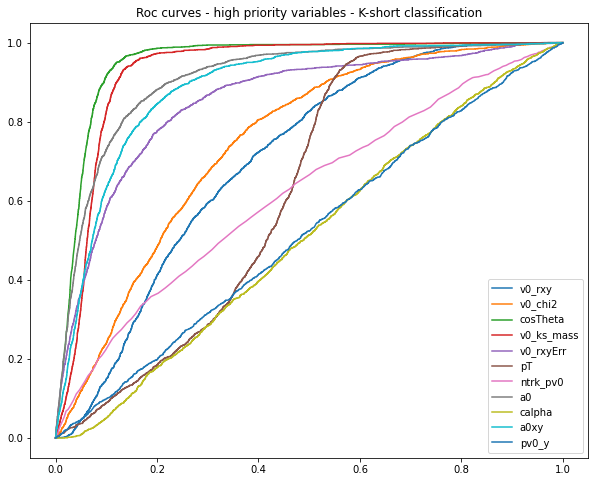

In [7]:
from sklearn.metrics import roc_curve, roc_auc_score

fig, ax = plt.subplots(figsize = (10, 8))

ax.set(title = "Roc curves - high priority variables - K-short classification")
aucs = {} # for recording auc_scores


for col in df_norm:
    auc = roc_auc_score(df_label, df_norm[col])
    if auc < .5:
        auc = 1 - auc
        scores = - df_norm[col]
    else:
        scores = df_norm[col]
    
    aucs[col] = auc
    
    x, y, _ = roc_curve(df_label, scores)
    
    
    
    ax.plot(x, y, label = col)
    

ax.legend(loc = "lower right")

print("AUC-scores are: " + ", ".join([f"{name}: {aucs[name]:.3f}" for name in aucs.keys()]))


## Fischer (4 vs 57 params)

Fischer (4 params) has auc: 0.980


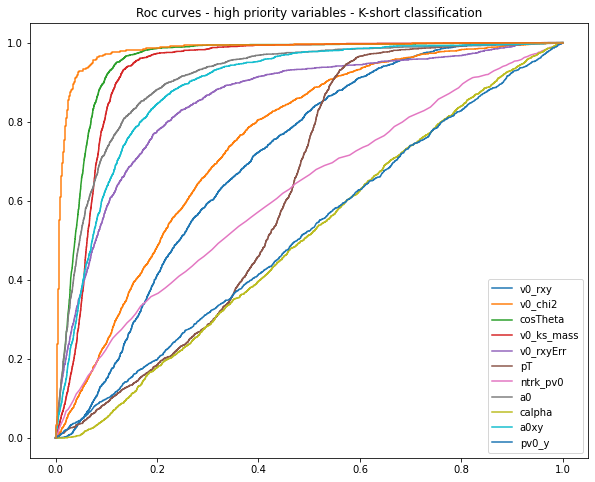

In [8]:
# Using the fischer discriminant can improve our results
# we use a test set for making roc_curves as we fit the fischer
# not really a problem, since few parameters for Fischer, but good practice.
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA().fit(df_norm.iloc[:train_amount, :], df_label[:train_amount])
    
score = lda.predict_proba(df_norm.iloc[train_amount:, :])

auc = roc_auc_score(df_label[train_amount:], score[:, 1])
aucs['fischer'] = auc

print(f"Fischer (4 params) has auc: {auc:.3f}")

x, y, _ = roc_curve(df_label[train_amount:], score[:, 1])

ax.plot(x, y, label = "Fischer (4 params)")
fig

Fischer (57 params)  has auc: 0.972


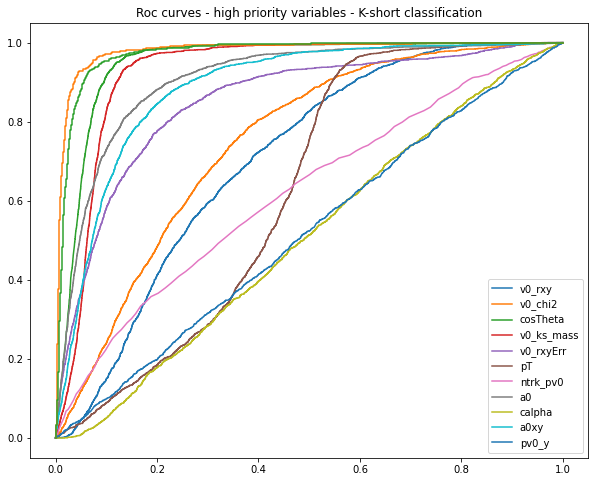

In [9]:
# Using the fischer discriminant can improve our results
# we use a test set for making roc_curves as we fit the fischer
# not really a problem, since few parameters for Fischer, but good practice
df_all_norm.v0_ks_mass = abs(df_all_norm.v0_ks_mass)

lda = LDA().fit(df_all_norm.iloc[:train_amount, :], df_all_label[:train_amount])
    
score = lda.predict_proba(df_all_norm.iloc[train_amount:, :])

auc = roc_auc_score(df_all_label[train_amount:], score[:, 1])
aucs['fischer_all'] = auc

print(f"Fischer (57 params)  has auc: {auc:.3f}")

x, y, _ = roc_curve(df_all_label[train_amount:], score[:, 1])

ax.plot(x, y, label = "Fischer (57 params)")
fig

## XGBoost

In [10]:
from xgboost import XGBClassifier, DMatrix

# Setup train and test data for xgboost
train_X = df_all_norm.iloc[:train_amount, :]
train_Y = df_all_label[:train_amount]
test_X = df_all_norm.iloc[train_amount:, :]
test_Y = df_all_label[train_amount:]

In [11]:
model = XGBClassifier(max_depth = 4).fit(train_X, train_Y)

XGBoost classifier has auc: 0.995


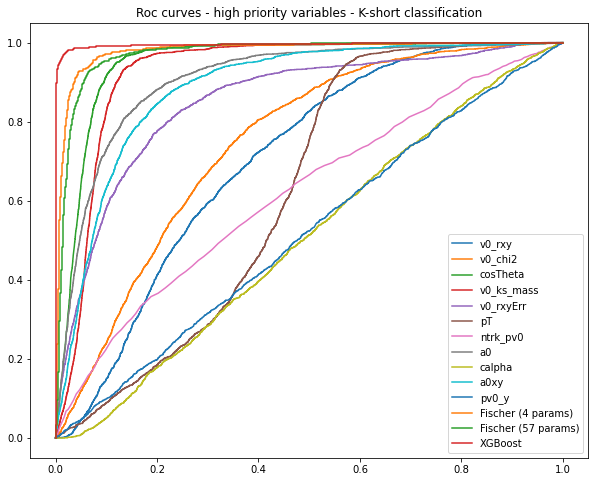

In [12]:
score = model.predict_proba(test_X)

auc = roc_auc_score(df_all_label[train_amount:], score[:, 1])
aucs['xgb'] = auc

print(f"XGBoost classifier has auc: {auc:.3f}")

x, y, _ = roc_curve(df_all_label[train_amount:], score[:, 1])

ax.plot(x, y, label = "XGBoost")
ax.legend(loc = "lower right")
fig

In [13]:
def predict_xgboost(df):
    df_all_norm = pd.DataFrame(None)
    for col in df_all.columns[:57]:
        if df[col].std() != 0:
            df_all_norm[col] = (df[col] - scalers[col][0]) / scalers[col][1]
    
    labels = model.predict(df_all_norm)
    return labels

import dill

seri = dill.dumps(predict_xgboost, recurse = True)

file = open("models/MC_trained_xgboost.dat", 'wb')
dill.dump(seri, file)
file.close()


seri = dill.dumps(model, recurse = True)

file = open('models/MC_trained_xgboost_whole.dat', 'wb')
dill.dump(seri, file)
file.close()

## Shap Values and lightGBM

LightGBM classifier has auc: 0.995


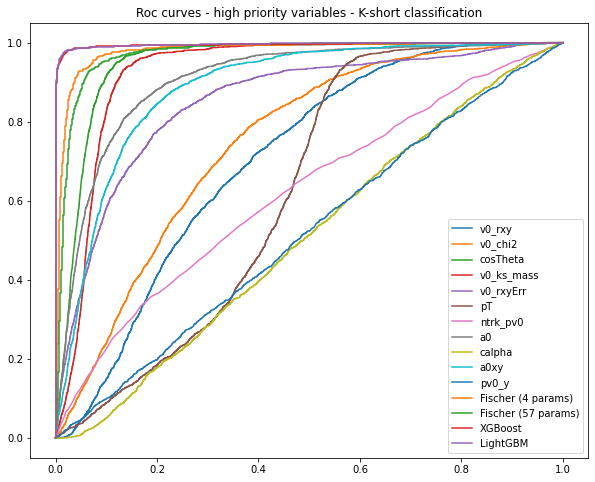

In [14]:
import shap
from lightgbm import LGBMClassifier


model = LGBMClassifier().fit(train_X, train_Y)

score = model.predict_proba(test_X)

auc = roc_auc_score(df_all_label[train_amount:], score[:, 1])
aucs['lgb'] = auc

print(f"LightGBM classifier has auc: {auc:.3f}")

x, y, _ = roc_curve(df_all_label[train_amount:], score[:, 1])

ax.plot(x, y, label = "LightGBM")
ax.legend(loc = "lower right")
fig

In [15]:

def predict_lightgbm(df):
    df_all_norm = pd.DataFrame(None)
    for col in df_all.columns[:57]:
        if df[col].std() != 0:
            df_all_norm[col] = (df[col] - scalers[col][0]) / scalers[col][1]
    
    labels = model.predict(df_all_norm)
    return labels
    
    

import dill

seri = dill.dumps(predict_lightgbm, recurse = True)

file = open("models/MC_trained_lightgbm.dat", 'wb')
dill.dump(seri, file)
file.close()


seri = dill.dumps(model, recurse = True)

file = open('models/MC_trained_lightGBM_whole.dat', 'wb')
dill.dump(seri, file)
file.close()

In [16]:
Explainer = shap.TreeExplainer(model)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [17]:
shap_values = Explainer.shap_values(test_X)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


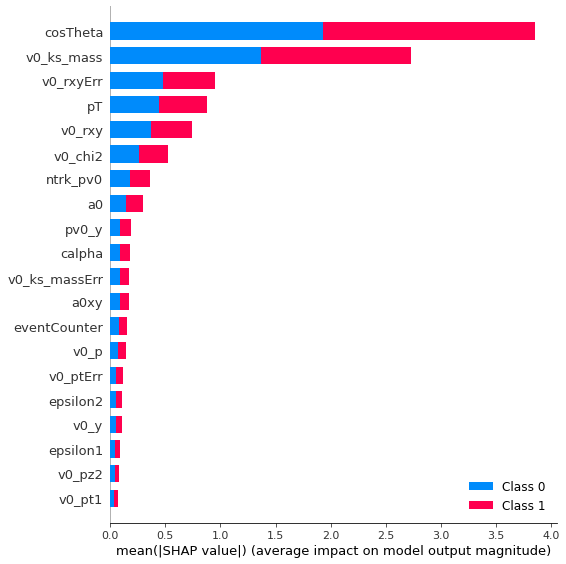

In [18]:
shap.summary_plot(shap_values, test_X)